In [32]:
import pandas as pd
from matplotlib import pyplot as plt
import glob
import matplotlib.dates as mdates
import numpy as np
from tqdm import tqdm
from datetime import timedelta

In [33]:
def reader(path, first_var):
    '''
    Reads SEMS/DASH data, adds datetime columns

    :param path: path to data file
    :param first_var: the name of the first column label
    :return: pandas DataFrame
    '''
    # Open the file and read the lines
    skip=1
    with open(path, "r") as file:
        # Iterate over the lines
        for line in file:
            # Strip leading and trailing whitespace
            line = line.strip()
            # Check if the line contains column names
            if line.startswith(first_var):
                # Split the line by whitespace and append to the columns list
                columns = line[1:].strip().split("\t")
                break
            skip+=1
    # Read the data into a DataFrame, skipping the first 6 rows of comments
    d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)
    #Check for duplicated metadata, remove metadata rows based on string "OPC SN"
    if len(d)>0:
        if isinstance(d.iloc[0,0], str):
            dup_meta = [n for n, i in enumerate(d.iloc[:,0]) if 'OPC SN' in i]
            if len(dup_meta) > 0:
                for line in dup_meta:
                    #Deletes duplicate metadata rows from dataframe
                    d.drop(np.arange(line,line+68), inplace = True)
                    d = d.apply(pd.to_numeric, errors='ignore')
                    
    # Creates datetime columns
    if 'DOY.Frac' in d.keys():
        d['dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['DOY.Frac'], unit='D') - pd.Timedelta(days=1)
    if 'StartTimeSt' in d.keys():
        d['st_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['StartTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'EndTimeSt' in d.keys():
        d['end_dt'] = pd.to_datetime('2024-1-1') + pd.to_timedelta(d['EndTimeSt'], unit='D') - pd.Timedelta(days=1)
    if 'YY/MM/DD' and 'HR:MN:SC' in d.keys():
        d['dt'] = pd.to_datetime(str(20) + d['YY/MM/DD'] + ' ' + d['HR:MN:SC'], format='%Y/%m/%d %H:%M:%S')
    return d

In [34]:
def glob_reader(file_key, first_var, subfolder = './data/'):
    '''
    Reads groups of data files and merges them into one

    :param file_key: shared key in filenames
    :param first_var: the name of the first column label
    :param subfolder: name of the subfolder containing the data
    :return: pandas DataFrame
    '''
    paths = sorted(glob.glob(subfolder+'*'+file_key+'*'))
    d = []
    for i in range(0, len(paths)):
        d.append(reader(paths[i], first_var))
    d = pd.concat(d).reset_index()
    return d

In [35]:
def add_bin_sum(d, apnd):
    d = d.copy()
    col_w_bin = [col for col in d.columns if 'bin' in col]
    d['bin_sum'+apnd] = d[col_w_bin].sum(numeric_only = True, axis=1)
    return d

In [36]:
def resamp(d):
    d = d.copy()
    d= d.resample('1s', on='dt').sum(numeric_only=True)
    return d.reset_index()

In [37]:
def read_all(subfolder):
    dopc = add_bin_sum(glob_reader('OPC_212', first_var= "#YY/MM/DD", subfolder=subfolder), '_dopc')
    hopc = add_bin_sum(glob_reader('OPC_210', first_var= "#YY/MM/DD", subfolder=subfolder), '_hopc')
    sems = glob_reader('SEMS_DATA', first_var= "#DOY.Frac", subfolder=subfolder)
    dash = glob_reader('DASH_FLOW', first_var= "#DOY.Frac", subfolder=subfolder)
    param = glob_reader('SAMP_PARAM', '#StartTimeSt', subfolder=subfolder)
    return dopc, hopc, sems, dash, param

In [38]:
def var_plot(dopc, hopc, sems, dash, param, vars, app):
    fig,axes = plt.subplots(len(vars), sharex='all', figsize=(8.5, 11/5*len(vars)))
    for i,ax in enumerate(axes.ravel()):
        v = vars[i]
        ax.set_ylabel(v)
        ax.grid(visible=True)
        if v in dopc.keys():
            lr_dopc = resamp(dopc)
            ax.plot(lr_dopc['dt'], lr_dopc[v], lw=.5, c='black')
            ax.scatter(dopc['dt'], dopc[v], s=.1, c='r')
        elif v in hopc.keys():
            lr_hopc = resamp(hopc)
            ax.plot(lr_hopc['dt'], lr_hopc[v], lw=.5, c='black')
            ax.scatter(hopc['dt'], hopc[v], s=.1, c='r')
        elif v in sems.keys():
            ax.plot(sems['dt'], sems[v], lw=.5, c='black')
            ax.scatter(sems['dt'], sems[v], c='r', s=.1, zorder=100)
        elif v in dash.keys():
            ax.plot(dash['dt'], dash[v], lw=.5, c='black')
            ax.scatter(dash['dt'], dash[v], c='r', s=.1, zorder=100)
        elif v in param.keys():
            x,y = [],[]
            for i in range(0, len(param)):
                    row = param.iloc[i]
                    x.extend([row['st_dt'], row['end_dt']])
                    y.extend([row[v], row[v]])
            ax.plot(x,y, c='black', lw=.5)
            ax.scatter(x,y, c='r', s=.1, zorder=100)

    date_format = mdates.DateFormatter('%H')
    ax.xaxis.set_major_formatter(date_format)
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    axes[0].set_title(str(dopc.iloc[0]['dt']) + ' − ' + str(dopc.iloc[-1]['dt']))
    #fig.suptitle(str(dopc.iloc[0]['dt']) + ' − ' + str(dopc.iloc[-1]['dt']))
    fig.tight_layout()
    fig.savefig('./figures/quick_looks-'+app+'.png', dpi=300, bbox_inches='tight')

In [39]:
def run_all(path, variables):
    dopc, hopc, sems, dash, param = read_all(path)
    var_plot(dopc, hopc, sems, dash, param, variables, '2024_05_30')

/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_93966/2429551755.py:23: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)
/var/folders/tf/wjndf74j55q6hwwhxhpzl0100000gn/T/ipykernel_93966/2429551755.py:23: DtypeWarning: Columns (2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88) have mixed types. Specify dtype option on import or set low_memory=False.
  d = pd.read_csv(path, sep='\t', skiprows=skip, names=columns)


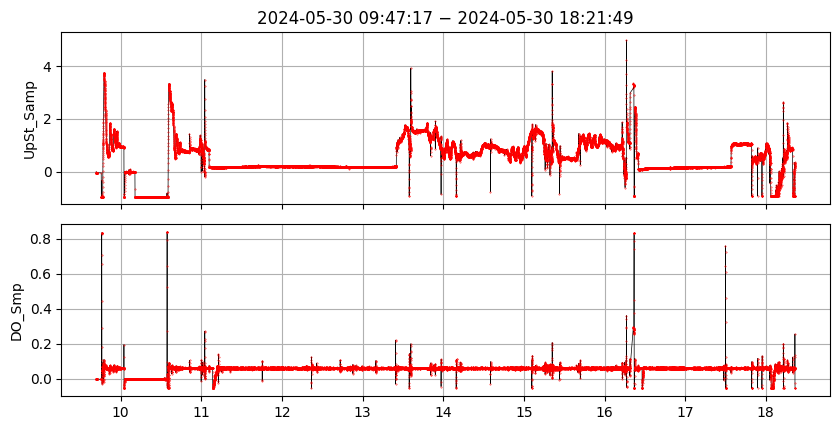

In [41]:
# enter the root path for all data, and list of variable names you would like to plot
run_all('./data/DASH-flight-2024_05_30/', ['UpSt_Samp', 'DO_Smp'])#, 'UpSt_Samp', 'DO_Smp', 'RH_Targ'])

Available Keys

In [10]:
'''
DOPC
['index', 'YY/MM/DD', 'HR:MN:SC', 'samp_intrvl', 'total_conc',
        'sample_flw', 'sheath_flw', 'sheath_temp', 'samp_press', 'lasr_brt',
        'lasr_cur', 'pmt_base_rd', 'pmt_base_pot_adj', 'sheath_pwr', 'exit_pwr',
        'opc_errs', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7',
        'bin8', 'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15',
        'bin16', 'bin17', 'bin18', 'bin19', 'bin20', 'bin21', 'bin22', 'bin23',
        'bin24', 'bin25', 'bin26', 'bin27', 'bin28', 'bin29', 'bin30', 'bin31',
        'bin32', 'bin33', 'bin34', 'bin35', 'bin36', 'bin37', 'bin38', 'bin39',
        'bin40', 'bin41', 'bin42', 'bin43', 'bin44', 'bin45', 'bin46', 'bin47',
        'bin48', 'bin49', 'bin50', 'bin51', 'bin52', 'bin53', 'bin54', 'bin55',
        'bin56', 'bin57', 'bin58', 'bin59', 'bin60', 'bin61', 'bin62', 'bin63',
        'bin64', 'bin65', 'bin66', 'bin67', 'bin68', 'bin69', 'bin70', 'bin71',
        'bin72', 'sd_save', 'sd_install', 'dt', 'bin_sum_dopc']

HOPC
['index', 'YY/MM/DD', 'HR:MN:SC', 'samp_intrvl', 'total_conc',
        'sample_flw', 'sheath_flw', 'sheath_temp', 'samp_press', 'lasr_brt',
        'lasr_cur', 'pmt_base_rd', 'pmt_base_pot_adj', 'sheath_pwr', 'exit_pwr',
        'opc_errs', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7',
        'bin8', 'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15',
        'bin16', 'bin17', 'bin18', 'bin19', 'bin20', 'bin21', 'bin22', 'bin23',
        'bin24', 'bin25', 'bin26', 'bin27', 'bin28', 'bin29', 'bin30', 'bin31',
        'bin32', 'bin33', 'bin34', 'bin35', 'bin36', 'bin37', 'bin38', 'bin39',
        'bin40', 'bin41', 'bin42', 'bin43', 'bin44', 'bin45', 'bin46', 'bin47',
        'bin48', 'bin49', 'bin50', 'bin51', 'bin52', 'bin53', 'bin54', 'bin55',
        'bin56', 'bin57', 'bin58', 'bin59', 'bin60', 'bin61', 'bin62', 'bin63',
        'bin64', 'bin65', 'bin66', 'bin67', 'bin68', 'bin69', 'bin70', 'bin71',
        'bin72', 'sd_save', 'sd_install', 'dt', 'bin_sum_hopc']

SEMS
['index', 'DOY.Frac', 'YYYY', 'Secs', 'UpSt_Sh', 'UpSt_Xs', 'UpSt_Samp',
        'UpSt_FAdj', 'UpSt_Rh', 'UpSt_T', 'UpSt_Press', 'UpSt_Dia', 'UpSt_HV',
        'dt']

DASH
['index', 'DOY.Frac', 'YYYY', 'Secs', 'DO_Sh', 'DO_Smp', 'DO_Press',
        'DO_Ht_T', 'DO_Ht_Pwr', 'DO_Fl_T', 'DO_X_T', 'HO_Sh_D_Fl', 'HO_Sh',
        'HO_Smp', 'HO_Press', 'HO_RH', 'HO_T', 'HO_Ht_T', 'HO_Ht_Pwr',
        'HO_Fl_T', 'HO_X_T', 'HO_DP_Cl', 'HO_DP_Lk', 'HM_Sh_D_Fl', 'HM_Sh',
        'HM_Xs', 'HM_Smp_Xs', 'HM_Press', 'HM_RH', 'HM_T', 'HM_Ht_T',
        'HM_Ht_Pwr', 'HM_Fl_T', 'HM_X_T', 'HM_DP_Cl', 'HM_DP_Lk', 'H2O_T',
        'H2O_Pwr', 'H2O_Lvl', 'H2O_Cnt', 'dt']

SAMP_PARAM       
['index', 'StartTimeSt', 'EndTimeSt', 'StartYr', 'EndYr', 'StartSecs',
        'EndSecs', 'Samp_Num', 'DO_Tot_Cnts', 'HO_Tot_Cnts', 'DO_Mode_Val',
        'HO_Mode_Val', 'UpSt_Dia', 'UpSt_Sh_Targ', 'RH_Targ', 'HO_Rh_Av',
        'HO_Rh_Sdev', 'HM_RH_Av', 'HM_Rh_Sdev', 'DO_Sh_Targ', 'DO_Sh_Av',
        'DO_Sh_Sdev', 'DO_Samp_Targ', 'DO_Samp_Av', 'DO_Samp_Sdev',
        'HO_Sh_Targ', 'HO_Sh_Av', 'HO_Sh_Sdev', 'HO_Samp_Targ', 'HO_Samp_Av',
        'HO_Samp_Sdev', 'HM_Sh_Targ', 'HM_Sh_Av', 'HM_Sh_Sdev', 'HM_Xs_Targ',
        'HM_Xs_Av', 'HM_Xs_Sdev', 'Samp_Xs_Targ', 'Samp_Xs_Av', 'Samp_Xs_Sdev',
        'st_dt', 'end_dt']
'''

"\nDOPC\n['index', 'YY/MM/DD', 'HR:MN:SC', 'samp_intrvl', 'total_conc',\n        'sample_flw', 'sheath_flw', 'sheath_temp', 'samp_press', 'lasr_brt',\n        'lasr_cur', 'pmt_base_rd', 'pmt_base_pot_adj', 'sheath_pwr', 'exit_pwr',\n        'opc_errs', 'bin1', 'bin2', 'bin3', 'bin4', 'bin5', 'bin6', 'bin7',\n        'bin8', 'bin9', 'bin10', 'bin11', 'bin12', 'bin13', 'bin14', 'bin15',\n        'bin16', 'bin17', 'bin18', 'bin19', 'bin20', 'bin21', 'bin22', 'bin23',\n        'bin24', 'bin25', 'bin26', 'bin27', 'bin28', 'bin29', 'bin30', 'bin31',\n        'bin32', 'bin33', 'bin34', 'bin35', 'bin36', 'bin37', 'bin38', 'bin39',\n        'bin40', 'bin41', 'bin42', 'bin43', 'bin44', 'bin45', 'bin46', 'bin47',\n        'bin48', 'bin49', 'bin50', 'bin51', 'bin52', 'bin53', 'bin54', 'bin55',\n        'bin56', 'bin57', 'bin58', 'bin59', 'bin60', 'bin61', 'bin62', 'bin63',\n        'bin64', 'bin65', 'bin66', 'bin67', 'bin68', 'bin69', 'bin70', 'bin71',\n        'bin72', 'sd_save', 'sd_install', 'd